## Import libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


## Show downloaded data

In [ ]:
df = pd.read_csv("archive/heart.csv")
print(df.head())  # Show the first few rows
# Encode categorical features
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Define feature and target variables
X = df.drop(columns=['HeartDisease'])  
y = df['HeartDisease']

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


## Split data into trainging, validation and test sets

In [ ]:
# Step 1: Split 70% training, 30% temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42) # using random_state(42) to garantie same splitting data

# Step 2: Split temp into 10% validation and 20% test
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

# Stratified split: 70% train, 10% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# print(y_train)

# Standardize numeric features for better training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print dataset sizes
print(f"Total dataset: {len(df)} samples")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Testing set: {len(test_df)} samples")

[0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1
 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0
 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1
 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0
 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1
 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0
 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1]
Total dataset: 500 samples
Training set: 350 samples
Validation set: 50 samples
Testing set: 100 samples


## Decision tree implementation

In [14]:
class Node:
    """Node to identify if it is internal node to split or leaf node to predict"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

    @classmethod
    def leaf(cls, label):
        return cls(label = label)

In [15]:
class DecisionTree:
    def __init__(self, max_depth = None):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        """Compute the entropy (H)"""
        # Count 0s, and 1s
        _, counts = np.unique(y, return_counts = True)
        # Compute probabilities of 0s, and 1s
        probs = counts / counts.sum()
        # Get the entropy
        return -np.sum(probs * np.log2(probs + 1e-9)) # Adding small number to avoid log of zero

    def information_gain(self, y, left_split, right_split):
        """Compute information gain (IG)"""
        # Compute H(Y)
        H_Y = self.entropy(y)
        # Compute H(Y|X = left)
        H_Y_left = self.entropy(y[left_split])
        # Compute H(Y|X = right)
        H_Y_right = self.entropy(y[right_split])
        # Compute H(Y|X)
        H_Y_X = (np.sum(left_split) / len(y)) * H_Y_left + (np.sum(right_split) / len(y)) * H_Y_right
        # Get the information gain
        return H_Y - H_Y_X

    def best_split(self, X, y):
        """Find the best numerical split"""
        best_feature, best_threshold, best_IG = None, None, 0
        best_left_split, best_right_split = None, None

        for feature in range(X.shape[1]):  # Iterate over features
            unique_values = np.unique(X[:, feature])
            
            if np.issubdtype(X[:, feature].dtype, np.number):  # 🔹 Numerical feature
                # Sort feature values
                unique_values = np.sort(unique_values)
                # Try splitting at midpoints between consecutive values
                for i in range(len(unique_values) - 1):
                    threshold = (unique_values[i] + unique_values[i + 1]) / 2  # Midpoint
                    left_split = X[:, feature] <= threshold
                    right_split = X[:, feature] > threshold
    
                    if np.sum(left_split) == 0 or np.sum(right_split) == 0:
                        continue  # Skip invalid splits
    
                    IG = self.information_gain(y, left_split, right_split)
                    if IG > best_IG:
                        best_IG, best_feature, best_threshold = IG, feature, threshold
                        best_left_split, best_right_split = left_split, right_split
            
            else:  # 🔹 Categorical feature
                for value in unique_values:
                    left_split = X[:, feature] == value
                    right_split = ~left_split  
    
                    if np.sum(left_split) == 0 or np.sum(right_split) == 0:
                        continue  
    
                    IG = self.information_gain(y, left_split, right_split)
                    if IG > best_IG:
                        best_IG, best_feature, best_threshold = IG, feature, value
                        best_left_split, best_right_split = left_split, right_split

        return best_feature, best_threshold, best_left_split, best_right_split

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree using threshold splits."""
        if len(set(y)) == 1:  # If only one class, return leaf node
            return Node.leaf(y[0])

        if self.max_depth and depth >= self.max_depth:
            return Node.leaf(np.bincount(y).argmax())  # Return most common label

        feature, threshold, left_split, right_split = self.best_split(X, y)

        if feature is None:
            return  Node.leaf(np.bincount(y).argmax())  # No valid split

        # Recursively build left and right subtrees
        left_subtree = self.build_tree(X[left_split, :], y[left_split], depth + 1)
        right_subtree = self.build_tree(X[right_split, :], y[right_split], depth + 1)

        
        return Node(feature, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        """Train the decision tree."""
        self.tree = self.build_tree(X, y)

    def predict_sample(self, node, x):
        """Predict a single sample recursively."""
        if node.label is not None:
            return node.label
        if isinstance(node.threshold, (int, float)):  # Numeric feature
            if x[node.feature] <= node.threshold:
                return self.predict_sample(node.left, x)
            else:
                return self.predict_sample(node.right, x)
        else:  # Categorical feature
            if x[node.feature] == node.threshold:
                return self.predict_sample(node.left, x)
            else:
                return self.predict_sample(node.right, x)

    def predict(self, X):
        """Predict multiple samples."""
        return np.array([self.predict_sample(self.tree, x) for x in X])

In [42]:
# Example dataset
data = pd.DataFrame({
    'Income': [35, 70, 60, 85, 40, 90],  # Numerical
    'CarType': ['Sedan', 'SUV', 'Sedan', 'Sedan', 'SUV', 'SUV'],  # Categorical
    'BuysCar': [0, 1, 0, 1, 0, 1]  # Target (0: No, 1: Yes)
})

# Convert categorical features to numerical (Label Encoding)
data['CarType'] = data['CarType'].astype('category').cat.codes  # Sedan=0, SUV=1

# Features (X) and target (y)
X = data[['Income', 'CarType']].values
y = data['BuysCar'].values

# Train the Decision Tree
tree = DecisionTree(max_depth=3)
tree.fit(X, y)

# Test Predictions
X_test = np.array([[30, 0], [75, 1], [55, 0], [95, 1]])  # Income, CarType
predictions = tree.predict(X_test)

print("Predictions:", predictions)


Predictions: [0 1 0 1]


## Bagging Implementation (bootstrap aggregation)

In [33]:
class BaggingClassifier:
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)  # Convert to NumPy for consistent indexing
        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
            model = self.base_estimator()
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)


In [ ]:
# Train Bagging Ensemble with Decision Trees
bagging = BaggingClassifier(lambda: DecisionTreeClassifier(max_depth=3), n_estimators=10)
bagging.fit(X_train_scaled, y_train)

# Predict
y_pred_bagging = bagging.predict(X_test_scaled)

# Print Evaluation Metrics
print("Bagging Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("Bagging F1-score:", f1_score(y_test, y_pred_bagging))


Bagging Accuracy: 0.51
Bagging F1-score: 0.5333333333333333
1.0


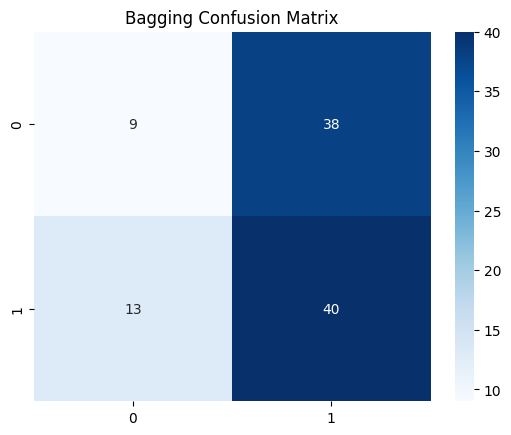

In [36]:
## Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_bagging), annot=True, fmt='d', cmap="Blues")
plt.title('Bagging Confusion Matrix')
plt.show()


# Bonus Section

## Logistic Regression (sigmoid function)

### Import Libraries

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



In [41]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_test_pred_logreg = logreg.predict(X_test)
# Print Evaluation Metrics
print("Logistic Accuracy:", accuracy_score(y_test, y_test_pred_logreg))
print("Logistic F1-score:", f1_score(y_test, y_test_pred_logreg))


Logistic Accuracy: 0.47
Logistic F1-score: 0.5826771653543307


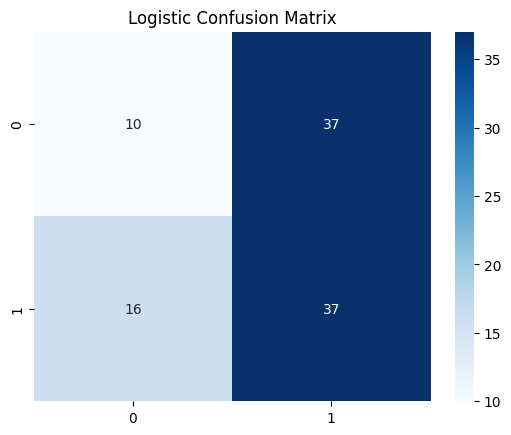

In [45]:
## Conflusion matix plot 
sns.heatmap(confusion_matrix(y_test, y_test_pred_logreg), annot=True, fmt='d', cmap="Blues")
plt.title('Logistic Confusion Matrix')
plt.show()